In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random
import os
import time

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

import gc
from tqdm import tqdm
import math

import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device('cpu')
device

device(type='cpu')

Reference: https://github.com/sayarghoshroy/Statistical-Machine-Translation/blob/master/SMT_English_to_Hindi.ipynb

 Clean Data Functions

In [3]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [5]:
start = time.time()

if os.path.isfile('./data/valid_subset.csv'):
    # cleaned, filtered by length, 10% dataset
    df = pd.read_csv('./data/valid_subset.csv', index_col=False)
    
elif os.path.isfile('./data/valid_cleaned_data.csv'):
    # cleaned, filtered by length dataset
    df = pd.read_csv('./data/valid_cleaned_data.csv', index_col=False)
    
elif os.path.isfile('./data/cleaned_data.csv'):
    # cleaned dataset
    df = pd.read_csv('./data/cleaned_data.csv', index_col=False)
else:

    df = pd.read_csv('./data/en-fr.csv')

end = time.time()
display(end - start)

df

0.28968214988708496

,en,fr
0,site map,plan du site
1,feedback,retroaction
2,credits,credits
3,francais,english
4,what is light ?,qu est ce que la lumiere ?
...,...,...
392285,regional programmes,les programmes regionaux
392286,papular genital lesions,pertes vaginales
392287,chancroid haemophilus ducreyi,chancre mou h mophilis ducreyi
392288,turnor lake b province,turnor lake b province


In [74]:
# Clean data only if not available    

start = time.time()
df.dropna(inplace=True)

if not os.path.isfile('./data/cleaned_data.csv'):
    df['en'] = df['en'].apply(lambda x: normalizeString(str(x)))
    df['fr'] = df['fr'].apply(lambda x: normalizeString(str(x)))
    df.to_csv('./data/cleaned_data.csv', index=False)
    
end = time.time()
display(end-start)

0.02581310272216797

In [75]:
### Filter dataset by length
MAX_LENGTH = 35

if not os.path.isfile('./data/valid_cleaned_data.csv'):
    # Assume df is your DataFrame and 'column_name' is the column you want to check
    string_length_required = 35  # Length of string in the column
    df = df[df['en'].str.len() <= string_length_required]
    df = df[df['fr'].str.len() <= string_length_required]

    
    df.to_csv('./data/valid_cleaned_data.csv', index=False)


df

,en,fr
0,site map,plan du site
1,feedback,retroaction
2,credits,credits
3,francais,english
4,what is light ?,qu est ce que la lumiere ?
...,...,...
392285,regional programmes,les programmes regionaux
392286,papular genital lesions,pertes vaginales
392287,chancroid haemophilus ducreyi,chancre mou h mophilis ducreyi
392288,turnor lake b province,turnor lake b province


Tokenize and Create Vocabulary

In [54]:
df_train = df.sample(frac=0.9)
df_p1 = pd.read_csv('./llama_test_data/byk_llama_test.csv')
df_p2 = pd.read_csv('./llama_test_data/mxl_llama_test.csv')
df_p3 = pd.read_csv('./llama_test_data/ytx_llama_test.csv')
df_test = pd.concat([df_p1, df_p2, df_p3])
df_train
#df_test = pd.concat([df, df_train])
#df_test.drop_duplicates(keep=False, inplace=True)
#df_train.reset_index(inplace=True, drop=True)
#df_test.reset_index(inplace=True, drop=True)

,en,fr
178815,c bill c,c projet de loi c
14956,discipline trace classifications,discipline classifications de trace
10657,deliver on brand promise,les amateurs de familiarite
159040,did the dollar crash ?,le dollar a t il chute ?
207168,evaluation challenges,defis poses par l evaluation
...,...,...
227985,total expenses,total des depenses
380702,n note s after,n note s apres
116880,saskatchewan commission on medicare,sustaining a quality system
270871,field rate amount,zone taux montant


In [17]:
english_sentences = df_train['en'].tolist()
french_sentences = df_train['fr'].tolist()

tokenized_en = [word_tokenize(sentence) for sentence in english_sentences]
tokenized_fr = [word_tokenize(sentence) for sentence in french_sentences]

In [18]:
from collections import Counter
import numpy as np

# Flatten lists and count word frequencies
en_words = Counter(word for sentence in tokenized_en for word in sentence)
fr_words = Counter(word for sentence in tokenized_fr for word in sentence)

en_vocab = len(en_words)
fr_vocab = len(fr_words)
en_vocab

69760

In [19]:
# creating the 't'
t = {}
data = {'en': tokenized_en, 'fr': tokenized_fr}
tdf = pd.DataFrame(data)
uniform = 1 / (en_vocab * fr_vocab)
tdf


,en,fr
0,"[mri, magnetic, resonance, imaging]","[l, imagerie, par, resonance, magnetique]"
1,"[northwest, territories]",[tno]
2,"[questionnaire, english, and, french]","[questionnaire, anglais, et, francais]"
3,"[weeds, key, issues]","[mauvaises, herbes, principaux, enjeux]"
4,"[plantevin, jerome]","[puxley, chinta]"
...,...,...
353056,"[mrs, mehnaz, ajmal, nationality]","[mme, mehnaz, ajmal, nationalite]"
353057,"[successful, at, learning, and]","[reussissent, leur, apprentissage]"
353058,"[poule, de, qualification, quarte]","[q, quarte, parade, de, quarte]"
353059,"[strongly, agree]","[totalement, en, accord]"


Expectation-Maximization Algorithm (from reference)

In [20]:
n_iters = 0
max_iters = 50

fine_tune = 1
has_converged = False

changes = []
if not os.path.isfile('final_translation_model.pkl'):
    while n_iters < max_iters and has_converged == False:
        has_converged = True
        max_change = -1

        n_iters += 1
        count = {}
        total = {}
        for index in range(len(tokenized_en)):
            s_total = {}
            for en_word in tokenized_en[index]:
                s_total[en_word] = 0
                for fr_word in tokenized_fr[index]:
                    if (en_word, fr_word) not in t:
                        t[(en_word, fr_word)] = uniform
                    s_total[en_word] += t[(en_word, fr_word)]

            for en_word in tokenized_en[index]:
                for fr_word in tokenized_fr[index]:
                    if (en_word, fr_word) not in count:
                        count[(en_word, fr_word)] = 0
                    count[(en_word, fr_word)] += (t[(en_word, fr_word)] / s_total[en_word])

                    if fr_word not in total:
                        total[fr_word] = 0
                    total[fr_word] += (t[(en_word, fr_word)] / s_total[en_word])

        # estimating the probabilities

        if fine_tune == 0:
            updated = {}

            for index in range(len(tokenized_en)):
                for fr_word in tokenized_fr[index]:
                    for en_word in tokenized_en[index]:
                        if (en_word, fr_word) in updated:
                            continue
                        updated[(en_word, fr_word)] = 1
                        if abs(t[(en_word, fr_word)] - count[(en_word, fr_word)] / total[fr_word]) > 0.01:
                            has_converged = False
                            max_change = max(max_change, abs(t[(en_word, fr_word)] - count[(en_word, fr_word)] / total[fr_word]))
                        t[(en_word, fr_word)] = count[(en_word, fr_word)] / total[fr_word]
        
        elif fine_tune == 1:
                # train it only for 1000 most frequent words in English and French
                max_words = 1000
                n_fr_words = 0
                updates = 0

                for fr_word_tuples in sorted(fr_words.items(), key = lambda k:(k[1], k[0]), reverse = True):
                    fr_word = fr_word_tuples[0]
                    n_fr_words += 1
                    if n_fr_words > max_words:
                        break
                    n_en_words = 0
                    for en_word_tuples in sorted(en_words.items(), key = lambda k:(k[1], k[0]), reverse = True):
                        en_word = en_word_tuples[0]
                        n_en_words += 1
                        if n_en_words > max_words:
                            break
                        if (en_word, fr_word) not in count or fr_word not in total:
                            continue
                            # assume = uniform in this case
                        else:
                            if abs(t[(en_word, fr_word)] - count[(en_word, fr_word)] / total[fr_word]) > 0.005:
                                has_converged = False
                                max_change = max(max_change, abs(t[(en_word, fr_word)] - count[(en_word, fr_word)] / total[fr_word]))
                            t[(en_word, fr_word)] = count[(en_word, fr_word)] / total[fr_word]
                

                print("Iteration " + str(n_iters) + " Completed, Maximum Change: " + str(max_change))

                changes.append(max_change)
    
    
 



Iteration 1 Completed, Maximum Change: 0.3905841310407161


KeyboardInterrupt: 

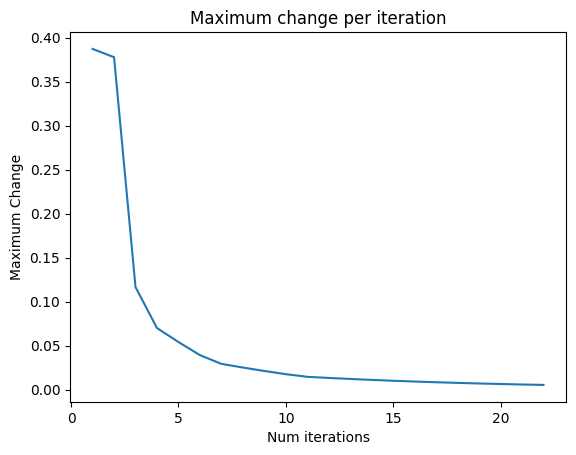

In [23]:
import matplotlib.pyplot as plt

iters = [i for i in range(1, 23)]

changes = [0.3873120883833188, 0.3779131577679606, 0.11644947148332752, 0.06989713947912918,  0.05399860149211433,0.039101991368349964,
            0.02915428347836463, 0.02500380364812338, 0.021059834762957474, 0.017462948788182775, 0.014428741448640092, 0.013170636150230397,
            0.012005883242324877, 0.010935993145647804, 0.009958588791638634, 0.009068769131450716, 0.00826034671566972, 0.0075267258611037,
            0.00686142403827722, 0.006258329972045784, 0.005711799475090096, 0.005216665532991882]

# Create a figure and axis
fig, ax = plt.subplots()

# Plot data
ax.plot(iters, changes)  # Adding a label for the legend

# Adding labels and title
ax.set_xlabel('Num iterations')  # X-axis label
ax.set_ylabel('Maximum Change')  # Y-axis label
ax.set_title('Maximum change per iteration')  # Title of the plot
fig.savefig('my_plot.png')

Save Data in pickle file

In [81]:
import pickle
# saving the translation model
file = open("translation_model.pkl","wb")
pickle.dump(t, file)
file.close()

In [10]:
import pickle
# using the model trained until convergence
model_name = "translation_model.pkl"
pickle_in = open(model_name,"rb")
t = pickle.load(pickle_in)

Display best translation pairs

In [9]:
"""
limit = 400
for element in sorted(t.items(), key = lambda k:(k[1], k[0]), reverse = True):
  print(element)
  limit -= 1
  if limit <= 0:
    break
"""


'\nlimit = 400\nfor element in sorted(t.items(), key = lambda k:(k[1], k[0]), reverse = True):\n  print(element)\n  limit -= 1\n  if limit <= 0:\n    break\n'

Testing Code and BLEU Metrics

In [33]:
df_test

,en,fr
0,authorship is inalienable and indefinite in time,droit de demander l enregistrement d un schema...
1,the owner of layout design shall be the person...,le titulaire du schema de configuration est la...
2,the owner enjoys full legal power exclusive ri...,le titulaire jouit de la totalite des droits d...
3,the rights of the owner of layout design may b...,les droits du titulaire du schema de configura...
4,application for registration of layout design ...,chapitre demande d enregistrement d un schema ...
...,...,...
48992,validity of licence upon deletion of registrat...,validite de la licence apres radiation de l en...
48993,definition of layout design of integrated circuit,objet de la protection juridique des schemas d...
48994,for the purposes of this act reproduction mean...,une partie d un schema de configuration de cir...
48995,where the layout design has been made through ...,le droit patrimonial du createur du schema de ...


In [30]:
def create_best(d):
    temp = {}
    iter = 0
    for en_word, fr_word in d:
        if en_word not in temp:
            temp[en_word] = fr_word
        else:
            if d[en_word, fr_word] > d[en_word, temp[en_word]]:
                temp[en_word] = fr_word
    return temp

best = create_best(t)

In [13]:
import pickle
# saving the translation model
file = open("best_trans.pkl","wb")
pickle.dump(best, file)
file.close()

In [14]:
import pickle
pickle_in = open("best_trans.pkl","rb")
best = pickle.load(pickle_in)

In [34]:
import datetime
tqdm.pandas()

def translate_row(s):
    pred = []
    list_s = s.split(' ')
    for word in list_s:
        if word in best:
            best_fr = best[word]
        else:
            best_fr = 'UNKNOWN!!!'
        pred.append(best_fr)
    return ' '.join(pred)


start = time.time()
df_test['trans'] = df_test['en'].progress_apply(lambda s:translate_row(s))

end = time.time()
print('translating ', len(df) ,' lines take ', str(datetime.timedelta(seconds = end-start)))

100%|██████████| 146993/146993 [00:00<00:00, 182068.46it/s]

translating  392290  lines take  0:00:00.864724


In [35]:
df_test

,en,fr,trans
0,authorship is inalienable and indefinite in time,droit de demander l enregistrement d un schema...,con est ses et indefinie dans temps
1,the owner of layout design shall be the person...,le titulaire du schema de configuration est la...,the numero cabinet mise conception le sera the...
2,the owner enjoys full legal power exclusive ri...,le titulaire jouit de la totalite des droits d...,the numero le temps juridique achat intrants d...
3,the rights of the owner of layout design may b...,les droits du titulaire du schema de configura...,the droits cabinet the numero cabinet mise con...
4,application for registration of layout design ...,chapitre demande d enregistrement d un schema ...,application pour enregistrement cabinet mise c...
...,...,...,...
48992,validity of licence upon deletion of registrat...,validite de la licence apres radiation de l en...,validite cabinet permis environnement diffused...
48993,definition of layout design of integrated circuit,objet de la protection juridique des schemas d...,definition cabinet mise conception cabinet la ...
48994,for the purposes of this act reproduction mean...,une partie d un schema de configuration de cir...,pour the culture cabinet cette loi iv l tout m...
48995,where the layout design has been made through ...,le droit patrimonial du createur du schema de ...,ou the mise conception ete ete fait sustainabi...


In [48]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
def bleu(truth,pred):
    return sentence_bleu([truth], pred, smoothing_function=SmoothingFunction().method1) #, weights=(1, 0, 0, 0)
# Applying it to two columns
df_test["bleu"] = df_test.progress_apply(lambda x: bleu(x["fr"], x["trans"]), axis=1)

100%|██████████| 146993/146993 [00:27<00:00, 5438.72it/s]


In [49]:
df_test

,en,fr,trans,bleu
0,authorship is inalienable and indefinite in time,droit de demander l enregistrement d un schema...,con est ses et indefinie dans temps,0.046122
1,the owner of layout design shall be the person...,le titulaire du schema de configuration est la...,the numero cabinet mise conception le sera the...,0.292671
2,the owner enjoys full legal power exclusive ri...,le titulaire jouit de la totalite des droits d...,the numero le temps juridique achat intrants d...,0.270201
3,the rights of the owner of layout design may b...,les droits du titulaire du schema de configura...,the droits cabinet the numero cabinet mise con...,0.446548
4,application for registration of layout design ...,chapitre demande d enregistrement d un schema ...,application pour enregistrement cabinet mise c...,0.438901
...,...,...,...,...
48992,validity of licence upon deletion of registrat...,validite de la licence apres radiation de l en...,validite cabinet permis environnement diffused...,0.338352
48993,definition of layout design of integrated circuit,objet de la protection juridique des schemas d...,definition cabinet mise conception cabinet la ...,0.248565
48994,for the purposes of this act reproduction mean...,une partie d un schema de configuration de cir...,pour the culture cabinet cette loi iv l tout m...,0.200732
48995,where the layout design has been made through ...,le droit patrimonial du createur du schema de ...,ou the mise conception ete ete fait sustainabi...,0.154417


In [50]:
df_test.to_csv('./data/bleuscoredsmt.csv', index=False)

In [51]:
final_df = pd.read_csv("./data/bleuscoredsmt.csv")
final_df

,en,fr,trans,bleu
0,authorship is inalienable and indefinite in time,droit de demander l enregistrement d un schema...,con est ses et indefinie dans temps,0.046122
1,the owner of layout design shall be the person...,le titulaire du schema de configuration est la...,the numero cabinet mise conception le sera the...,0.292671
2,the owner enjoys full legal power exclusive ri...,le titulaire jouit de la totalite des droits d...,the numero le temps juridique achat intrants d...,0.270201
3,the rights of the owner of layout design may b...,les droits du titulaire du schema de configura...,the droits cabinet the numero cabinet mise con...,0.446548
4,application for registration of layout design ...,chapitre demande d enregistrement d un schema ...,application pour enregistrement cabinet mise c...,0.438901
...,...,...,...,...
146988,validity of licence upon deletion of registrat...,validite de la licence apres radiation de l en...,validite cabinet permis environnement diffused...,0.338352
146989,definition of layout design of integrated circuit,objet de la protection juridique des schemas d...,definition cabinet mise conception cabinet la ...,0.248565
146990,for the purposes of this act reproduction mean...,une partie d un schema de configuration de cir...,pour the culture cabinet cette loi iv l tout m...,0.200732
146991,where the layout design has been made through ...,le droit patrimonial du createur du schema de ...,ou the mise conception ete ete fait sustainabi...,0.154417


In [52]:
final_df.iloc[:, 3].mean()

0.33199346742208236

In [53]:
final_df.nlargest(10, 'bleu')


,en,fr,trans,bleu
1908,annex i chapter i point c annex i chapter i po...,annexe i chapitre i point c annexe i chapitre ...,annexe i chapitre i point c annexe i chapitre ...,1.0
1909,annex i chapter i point c e annex i chapter i ...,annexe i chapitre i point c e annexe i chapitr...,annexe i chapitre i point c e annexe i chapitr...,1.0
1928,annex i chapter i point c annex i chapter i po...,annexe i chapitre i point c annexe i chapitre ...,annexe i chapitre i point c annexe i chapitre ...,1.0
1982,annex i chapter i point e annex i chapter i po...,annexe i chapitre i point e annexe i chapitre ...,annexe i chapitre i point e annexe i chapitre ...,1.0
1987,annex i chapter i point c annex i chapter i po...,annexe i chapitre i point c annexe i chapitre ...,annexe i chapitre i point c annexe i chapitre ...,1.0
1989,annex i chapter i point b c annex i chapter i ...,annexe i chapitre i point b c annexe i chapitr...,annexe i chapitre i point b c annexe i chapitr...,1.0
1991,annex i chapter i point c d annex i chapter i ...,annexe i chapitre i point c d annexe i chapitr...,annexe i chapitre i point c d annexe i chapitr...,1.0
1992,annex i chapter i point e annex i chapter i po...,annexe i chapitre i point e annexe i chapitre ...,annexe i chapitre i point e annexe i chapitre ...,1.0
2054,annex i chapter iv point b annex i chapter iv ...,annexe i chapitre iv point b annexe i chapitre...,annexe i chapitre iv point b annexe i chapitre...,1.0
2080,annex i chapter i point e annex i chapter i point,annexe i chapitre i point e annexe i chapitre ...,annexe i chapitre i point e annexe i chapitre ...,1.0
